
# 표정 기반 피로도(전처 단계) — FER2013 감정 분류 가중치 학습 노트북

이 노트북은 **FER2013** 감정 분류 모델을 빠르게 학습해 **가중치(.pth)** 파일을 저장합니다.  
추후 피로도 스코어링(Valence–Arousal, EAR/MAR 결합 등)의 **전처 기반(감정 확률)** 으로 바로 사용할 수 있습니다.

> **요약**
> - 데이터: FER2013 (Kaggle `msambare/fer2013`) — *자동 다운로드(선택)*
> - 모델: MobileNetV3-Small (pretrained)
> - 손실: CrossEntropy
> - 전략: Stratified Train/Val split, AMP, Cosine LR, Early Stopping
> - 결과: `weights/fer_mobilenetv3_small_best.pth` + `class_to_idx.json`
    


## 0. 준비 사항
- (선택) Kaggle API 사용시: `~/.kaggle/kaggle.json` 배치 필요
- 또는 `data/fer2013/` 폴더에 **ImageFolder 구조**(`train/class_x/*.jpg`, `test/class_x/*.jpg`)로 미리 데이터 배치
    

In [1]:

# 환경 체크
import sys, torch, torchvision
print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.cuda.is_available(), torch.cuda.device_count())
print("Torchvision:", torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Torch : 2.7.1+cu126
CUDA  : True 1
Torchvision: 0.22.1+cu126


device(type='cuda')


## 1. (선택) Kaggle에서 FER2013 다운로드
- Kaggle 토큰이 있으면 자동으로 `msambare/fer2013`를 내려받아 `data/fer2013`에 전개합니다.
- 토큰이 없으면 **이 셀을 건너뛰고**, 이미 준비된 `data/fer2013`을 사용하세요.
    

In [2]:

import os, zipfile, shutil, subprocess, sys

DATA_DIR = "data/fer2013"
os.makedirs("data", exist_ok=True)

def has_kaggle_token():
    home = os.path.expanduser("~")
    return os.path.exists(os.path.join(home, ".kaggle", "kaggle.json"))

if has_kaggle_token() and not os.path.exists(DATA_DIR):
    print("Kaggle token detected. Downloading FER2013...")
    try:
        # install kaggle cli if missing
        try:
            import kaggle  # noqa
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaggle"])
        # download
        subprocess.check_call(["kaggle", "datasets", "download", "-d", "msambare/fer2013", "-p", "data"])
        # unzip
        zip_path = "data/fer2013.zip"
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall("data")
        # dataset unzips to data/fer2013
        print("Unzipped to data/fer2013")
    except subprocess.CalledProcessError as e:
        print("Kaggle download failed:", e)
else:
    if os.path.exists(DATA_DIR):
        print("Using existing data at:", DATA_DIR)
    else:
        print("No Kaggle token and no data/fer2013 folder found.")
        print("Please prepare FER2013 in ImageFolder format under data/fer2013.")


Kaggle token detected. Downloading FER2013...
Unzipped to data/fer2013



## 2. 데이터 구조 확인 & 클래스 라벨 정리
- FER2013 Kaggle 버전의 경우 `data/fer2013/train` & `data/fer2013/test`에 클래스별 폴더가 있습니다.
- 여기서는 **train**에서 stratified split으로 **val**을 생성합니다.
    

In [3]:

import os
from glob import glob

root = "data"
train_root = os.path.join(root, "train")
test_root  = os.path.join(root, "test")

print("Exists:", os.path.exists(train_root), os.path.exists(test_root))
if os.path.exists(train_root):
    classes = sorted([d for d in os.listdir(train_root) if os.path.isdir(os.path.join(train_root, d))])
    print("Classes:", classes)
else:
    classes = []


Exists: True True
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [38]:
## 사람들의 감정 데이터

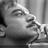

In [37]:
data_dir = 'data/train'
dataset = datasets.ImageFolder(data_dir)
dataset.__getitem__(1)[0]
dataset.__getitem__(3)[0]




## 3. 데이터셋/데이터로더 구성
- Augmentations: RandomResizedCrop, RandomHorizontalFlip, ColorJitter(약하게), RandomGrayscale(약하게)
- 입력 크기: 224×224 (MobileNetV3 권장)
- Stratified Split: train → train/val (기본 90:10)
    

In [4]:

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np, json, os

IMG_SIZE = 224
BATCH_SIZE = 128
VAL_RATIO = 0.1
NUM_WORKERS = 4

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset_full = datasets.ImageFolder(train_root, transform=train_tfms)
y_full = np.array([label for _, label in train_dataset_full.samples])

sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros_like(y_full), y_full))

train_dataset = Subset(train_dataset_full, train_idx)
# validation은 augmentation 없이 고정 transform 사용
val_dataset_full = datasets.ImageFolder(train_root, transform=val_tfms)
val_dataset = Subset(val_dataset_full, val_idx)

test_dataset = datasets.ImageFolder(test_root, transform=val_tfms) if os.path.exists(test_root) else None

class_to_idx = train_dataset_full.class_to_idx
os.makedirs("weights", exist_ok=True)
with open("weights/class_to_idx.json", "w", encoding="utf-8") as f:
    json.dump(class_to_idx, f, ensure_ascii=False, indent=2)
print("Saved class_to_idx:", class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True) if test_dataset else None

len(train_dataset), len(val_dataset), (len(test_dataset) if test_dataset else None)


Saved class_to_idx: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


(25838, 2871, 7178)

In [7]:
a = next(iter(test_loader))


## 4. 모델 정의 (MobileNetV3-Small, pretrained)
- 출력 차원 = 클래스 수
- Optim: AdamW
- Scheduler: CosineAnnealingLR
- AMP(autocast + GradScaler) 사용
    

In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

num_classes = len(class_to_idx) if class_to_idx else 7  # FER2013 일반적으로 7클래스
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
epochs = 30

# 총 스텝 기반이 아니므로 간단히 CosineAnnealingLR 사용
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\hamseungjun/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100%|█████████████████████████████████████████████████████████████████████████████| 9.83M/9.83M [00:00<00:00, 97.8MB/s]
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\1309777606.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))



## 5. 학습 루프 (조기 종료 + F1 계산)
- EarlyStopping: 검증 F1이 `patience` 동안 개선 없으면 종료
- 지표: Accuracy, Macro-F1
    

In [11]:

from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import time

def evaluate(model, loader, device):
    model.eval()
    ys, yhs = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(x)
            yh = logits.argmax(1)
            ys.append(y.detach().cpu().numpy())
            yhs.append(yh.detach().cpu().numpy())
    ys  = np.concatenate(ys)
    yhs = np.concatenate(yhs)
    acc = accuracy_score(ys, yhs)
    f1  = f1_score(ys, yhs, average="macro")
    return acc, f1

best_f1 = -1.0
patience = 7
pat = 0
best_path = "weights/fer_mobilenetv3_small_best.pth"

for ep in range(1, epochs+1):
    model.train()
    t0 = time.time()
    losses = []
    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
    scheduler.step()
    
    val_acc, val_f1 = evaluate(model, val_loader, device)
    tr_loss = float(np.mean(losses))
    dt = time.time() - t0
    print(f"[{ep:02d}/{epochs}] loss={tr_loss:.4f}  val_acc={val_acc:.4f}  val_f1={val_f1:.4f}  time={dt:.1f}s")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        pat = 0
        torch.save({"state_dict": model.state_dict(),
                    "class_to_idx": class_to_idx,
                    "epoch": ep}, best_path)
        print(f"  ↳ Best improved. Saved to {best_path}")
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping triggered.")
            break

print("Best val_f1:", best_f1)


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[01/30] loss=1.2231  val_acc=0.5670  val_f1=0.4457  time=75.4s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[02/30] loss=0.9914  val_acc=0.6102  val_f1=0.5436  time=41.6s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[03/30] loss=0.9068  val_acc=0.6454  val_f1=0.6090  time=42.5s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[04/30] loss=0.8507  val_acc=0.6385  val_f1=0.5966  time=47.9s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[05/30] loss=0.7875  val_acc=0.6437  val_f1=0.5977  time=41.8s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[06/30] loss=0.7344  val_acc=0.6242  val_f1=0.5658  time=39.5s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[07/30] loss=0.6851  val_acc=0.6461  val_f1=0.6040  time=37.1s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[08/30] loss=0.6275  val_acc=0.6520  val_f1=0.6170  time=37.2s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[09/30] loss=0.5662  val_acc=0.6527  val_f1=0.5999  time=35.7s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[10/30] loss=0.5090  val_acc=0.6552  val_f1=0.6257  time=33.7s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[11/30] loss=0.4547  val_acc=0.6618  val_f1=0.6318  time=32.8s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[12/30] loss=0.3990  val_acc=0.6614  val_f1=0.6359  time=33.4s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[13/30] loss=0.3391  val_acc=0.6628  val_f1=0.6322  time=32.7s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[14/30] loss=0.2978  val_acc=0.6750  val_f1=0.6374  time=32.8s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[15/30] loss=0.2543  val_acc=0.6559  val_f1=0.6208  time=32.7s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[16/30] loss=0.2249  val_acc=0.6566  val_f1=0.6201  time=34.1s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[17/30] loss=0.1896  val_acc=0.6698  val_f1=0.6401  time=34.0s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[18/30] loss=0.1532  val_acc=0.6614  val_f1=0.6462  time=39.2s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[19/30] loss=0.1319  val_acc=0.6684  val_f1=0.6428  time=36.1s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[20/30] loss=0.1157  val_acc=0.6750  val_f1=0.6424  time=34.4s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[21/30] loss=0.0980  val_acc=0.6803  val_f1=0.6534  time=36.5s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[22/30] loss=0.0832  val_acc=0.6890  val_f1=0.6665  time=39.9s
  ↳ Best improved. Saved to weights/fer_mobilenetv3_small_best.pth


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[23/30] loss=0.0736  val_acc=0.6855  val_f1=0.6600  time=39.2s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[24/30] loss=0.0651  val_acc=0.6893  val_f1=0.6605  time=38.6s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[25/30] loss=0.0591  val_acc=0.6921  val_f1=0.6628  time=38.8s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[26/30] loss=0.0542  val_acc=0.6942  val_f1=0.6642  time=38.9s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[27/30] loss=0.0477  val_acc=0.6931  val_f1=0.6630  time=38.1s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[28/30] loss=0.0440  val_acc=0.6890  val_f1=0.6583  time=38.1s


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[29/30] loss=0.0431  val_acc=0.6907  val_f1=0.6622  time=39.2s
Early stopping triggered.
Best val_f1: 0.6664689422319084



## 6. 테스트(선택)
- Kaggle FER2013에는 `test` 폴더가 있습니다. 존재하면 테스트 점수도 확인합니다.
    

In [12]:

if test_loader is not None:
    ckpt = torch.load("weights/fer_mobilenetv3_small_best.pth", map_location=device)
    model.load_state_dict(ckpt["state_dict"])
    test_acc, test_f1 = evaluate(model, test_loader, device)
    print(f"[TEST] acc={test_acc:.4f}, macro-f1={test_f1:.4f}")
else:
    print("No test set detected — skipped.")


C:\Users\hamseungjun\AppData\Local\Temp\ipykernel_31292\2481922711.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[TEST] acc=0.6828, macro-f1=0.6716



## 7. (선택) TorchScript 내보내기
- 실시간 추론 배포를 위한 TorchScript 파일도 저장합니다.
    

In [13]:

# TorchScript export (optional)
script_path = "weights/fer_mobilenetv3_small_best.ts"
ckpt = torch.load("weights/fer_mobilenetv3_small_best.pth", map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

example = torch.randn(1, 3, 224, 224, device=device)
traced = torch.jit.trace(model, example)
traced.save(script_path)
print("Saved TorchScript:", script_path)


Saved TorchScript: weights/fer_mobilenetv3_small_best.ts



## 8. 다음 단계 (피로도 스코어링 결합)
- 위 모델의 **감정 확률**을 이용해, 다음과 같이 피로도 스코어를 만들 수 있습니다.
  - `p_neg = p(sad)+p(disgust)+p(angry)+α·p(neutral)`
  - Valence/Arousal 회귀 모델(추가 학습) 또는 AU(눈감김/하품) 피쳐와 합성
- 별도 요청 시: **EAR/MAR 계산 + 실시간 FatigueScore** 추론 노트북/웹 데모 제공 가능
    

In [3]:
# === 감정 확률 → 피로도 스코어 산출 ===
# 전제: weights/fer_mobilenetv3_small_best.pth, weights/class_to_idx.json 존재
import os, json, math, torch, numpy as np
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.models import mobilenet_v3_small

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) 클래스 매핑 로드
with open("weights/class_to_idx.json", "r", encoding="utf-8") as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("idx_to_class:", idx_to_class)

# FER2013 일반 클래스(예시): angry, disgust, fear, happy, neutral, sad, surprise
NEG_LABELS = ["sad", "disgust", "angry"]   # 피로에 기여하는 부정 감정 집합
NEUTRAL_LABEL = "neutral"
ALPHA_NEUTRAL = 0.5                        # 중립 가중치 α

# 2) 모델 로드 (학습한 가중치 불러오기)
num_classes = len(class_to_idx)
model = mobilenet_v3_small(weights=None)
# classifier[3]가 최종 Linear(개수는 torchvision 버전에 따라 달라질 수 있음)
# 아래는 최신 기준(MobileNetV3-Small의 마지막 Linear가 classifier[3])에 맞춤
in_features = model.classifier[3].in_features
model.classifier[3] = torch.nn.Linear(in_features, num_classes)
ckpt = torch.load("weights/fer_mobilenetv3_small_best.pth", map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval().to(device)

# 3) 전처리(검증과 동일)
IMG_SIZE = 224
inference_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

@torch.no_grad()
def predict_emotion_probs(img: Image.Image, temperature: float = 1.0):
    """
    입력: PIL Image
    출력: 감정 확률 dict 예) {"angry":0.01, "happy":0.72, ...}
    """
    x = inference_tfms(img).unsqueeze(0).to(device)
    logits = model(x)
    if temperature is not None and temperature > 0:
        logits = logits / float(temperature)
    probs = F.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    probs_dict = {idx_to_class[i]: float(probs[i]) for i in range(len(probs))}
    return probs_dict

# 4) 피로도 스코어러 (감정 확률 기반 + 선택적 AU 훅)
class FatigueScorer:
    """
    감정 확률 기반 피로도 스코어러
    - 기본: p_neg = p(sad)+p(disgust)+p(angry) + α·p(neutral)
    - 선택: eye_close, yawn(0~1)을 받아 AU 결합 가능
    - EWMA(β)로 시간 평활
    최종 FatigueScore ∈ [0, 100]
    """
    def __init__(self, w_neg=1.0, w_au_eye=0.0, w_au_yawn=0.0, beta=0.9):
        self.w_neg = float(w_neg)
        self.w_au_eye = float(w_au_eye)
        self.w_au_yawn = float(w_au_yawn)
        self.beta = float(beta)
        self.state = 0.0  # EWMA 내부 상태

    def _p_neg(self, probs_dict):
        s = 0.0
        for lab in NEG_LABELS:
            if lab in probs_dict:
                s += probs_dict[lab]
        if NEUTRAL_LABEL in probs_dict:
            s += ALPHA_NEUTRAL * probs_dict[NEUTRAL_LABEL]
        return float(np.clip(s, 0.0, 1.0))

    def score_frame(self, probs_dict, eye_close=0.0, yawn=0.0):
        # 감정 기반 원시 점수
        s = self.w_neg * self._p_neg(probs_dict)
        # AU(선택)
        s += self.w_au_eye * float(np.clip(eye_close, 0.0, 1.0))
        s += self.w_au_yawn * float(np.clip(yawn, 0.0, 1.0))
        s = float(np.clip(s, 0.0, 1.0))
        # EWMA 평활
        self.state = self.beta * self.state + (1.0 - self.beta) * s
        fatigue = 100.0 * float(np.clip(self.state, 0.0, 1.0))
        return fatigue, s  # (평활 점수, 원시 점수)

    def reset(self):
        self.state = 0.0

# 기본: 감정만 사용 (w_neg=1.0)
scorer = FatigueScorer(w_neg=1.0, w_au_eye=0.0, w_au_yawn=0.0, beta=0.9)

def fatigue_from_image_path(img_path, temperature=1.0, eye_close=0.0, yawn=0.0):
    """
    경로 이미지 한 장에서 피로도 스코어 계산
    반환: (probs_dict, raw_score_0to1, fatigue_0to100)
    """
    img = Image.open(img_path).convert("RGB")
    probs = predict_emotion_probs(img, temperature=temperature)
    fatigue, raw = scorer.score_frame(probs, eye_close=eye_close, yawn=yawn)
    return probs, raw, fatigue

# === 사용 예시 ===
# 1) 단일 이미지
demo_img = "demo.jpg"  # 테스트할 이미지 경로
if os.path.exists(demo_img):
    probs, raw, fatigue = fatigue_from_image_path(demo_img, temperature=1.0)
    print(json.dumps(probs, ensure_ascii=False, indent=2))
    print(f"raw={raw:.3f}, fatigue={fatigue:.1f}")
else:
    print("demo.jpg가 없습니다. 경로를 바꿔 실행하세요.")

# 2) 폴더 일괄 처리
from glob import glob
def batch_fatigue_on_folder(folder="demo_images"):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    paths = []
    for e in exts:
        paths += glob(os.path.join(folder, e))
    if not paths:
        print("폴더에 이미지가 없습니다:", folder)
        return
    scorer.reset()
    rows = []
    for p in sorted(paths):
        probs, raw, fatigue = fatigue_from_image_path(p)
        rows.append((p, raw, fatigue))
        print(f"{os.path.basename(p):30s} raw={raw:.3f} fatigue={fatigue:.1f}")
    fats = [f for _, _, f in rows]
    print(f"Summary: n={len(rows)}  mean={np.mean(fats):.1f}  max={np.max(fats):.1f}")
    return rows

# 3) AU(눈감김/하품) 결합 예시 (가상 값)
scorer = FatigueScorer(w_neg=0.6, w_au_eye=0.3, w_au_yawn=0.1, beta=0.9)
if os.path.exists("demo.jpg"):
    fake_eye_close = 0.4  # 최근 10초 눈감김 비율(예)
    fake_yawn = 0.2       # 하품 강도/빈도(예)
    probs = predict_emotion_probs(Image.open("demo.jpg").convert("RGB"))
    fatigue, raw = scorer.score_frame(probs, eye_close=fake_eye_close, yawn=fake_yawn)
    print(f"[With AU] raw={raw:.3f} fatigue={fatigue:.1f}")


idx_to_class: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
{
  "angry": 1.71044989283331e-09,
  "disgust": 8.918034088978288e-10,
  "fear": 0.004994899500161409,
  "happy": 1.2655708303555002e-07,
  "neutral": 0.00042139278957620263,
  "sad": 0.994579553604126,
  "surprise": 4.049762992508477e-06
}
raw=0.995, fatigue=9.9
[With AU] raw=0.737 fatigue=7.4
